In [ ]:
import pandas as pd

In [ ]:
# df = pd.read_csv('../data/sales.csv')
df = pd.read_csv('sales.csv')

In [ ]:
df.dropna(subset=['price'], inplace=True)

In [ ]:
df.head()

,cost,price,weight,purchase_date,product_type,product_level,maker,ingredient,height,width,depth
0,$333k,"$300,492",3 Ton 90 Kg,Dec 19 2008,"Q,B",advanced,M14122,"IN732052,IN732053",2.76 meters,97 cm,26 cm
1,NaN,"$430,570",3 Ton 30 Kg,Sep 10 1997,"J,D",basic,NaN,"IN732054,IN732055,IN732056,IN732057,IN732058",2.67 meters,98 cm,26 cm
2,$270k,"$213,070",3 Ton 40 Kg,Sep 05 2001,"J,D",basic,NaN,"IN732054,IN732059,IN732060",3.0 meters,93 cm,24 cm
3,NaN,"$229,174",3 Ton 50 Kg,Dec 23 2016,U,advanced,M14123,"IN732061,IN732062,IN732063",2.5 meters,102 cm,27 cm
4,$97k,"$122,659",2 Ton 970 Kg,Jan 12 2000,"D,R",advanced,NaN,"IN732064,IN732065,IN732066",2.47 meters,101 cm,26 cm


In [ ]:
df['year'] = pd.to_datetime(df.purchase_date).dt.year

train_raw = df[df.year < 2015].reset_index(drop=True)
test_raw = df[df.year >= 2015].reset_index(drop=True)

# 1. Dummy Transformer

<font color='red'>Question:</font> What are dummy variables?

**ANS:**
<br>Dummy variables are numeical variables (0 or 1) that represent categorical data. **One-hot encoding**

**Example:** Class to transform **product_level** to dummy variables. 

In [ ]:
class Dummy_Transformer(object):
    
    def fit(self, X, y=None):
        self.keys = set(X)
    
    def transform(self, X, y=None):
        res = {}
        for key in self.keys:
            res[key] = [0]*len(X)    
        for i, item in enumerate(X):
            if item in self.keys:
                res[item][i] = 1
        return pd.DataFrame(res)
    
    def fit_transform(self, X, y=None):
        self.fit(X)
        return self.transform(X)        

In [ ]:
dummytf = Dummy_Transformer()

In [ ]:
dummytf.fit_transform(df.product_level).head()

,basic,super advanced,advanced,intermediate,unrated
0,0,0,1,0,0
1,1,0,0,0,0
2,1,0,0,0,0
3,0,0,1,0,0
4,0,0,1,0,0


##### <font color='red'>Question:</font> any potential issues with this method?

<font color='red'>Assignment:</font> Wrap up the above dummy transformer with LinearRegression as pipeline to predict **price**. 

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline

feature = "product_level"
target = "price"

def price2num(x):
    if isinstance(x, str):
        x = x.strip("$").replace(",","")
    return float(x)

X_train = train_raw[feature]
y_train = train_raw[target].map(price2num)

X_test = test_raw[feature]
y_test = test_raw[target].map(price2num)

steps = [("dtf", Dummy_Transformer()), ("lr", LinearRegression())]

model = Pipeline(steps)
model = model.fit(X_train, y_train)

NameError: ignored

In [ ]:
'''Train data visualization'''
import matplotlib.pylab as plt
%matplotlib inline

y_train_pred = model.predict(X_train)

plt.scatter(y_train, y_train_pred, alpha=0.3)


In [ ]:
'''Test data visualization'''

y_test_pred = model.predict(X_test)

plt.scatter(y_test, y_test_pred, alpha=0.3)

# 2. Frequence Transformer

<font color='red'>Assignment:</font> Write a class to replace the categorical values in **product_level** with their frequencies.

**steps**
1. calculate the count/frequency of each product_level
2. replace the original product_level by the fequecny of that product_level

In [ ]:
class Freq_Transformer():
    
    def fit(self, X, y=None):
        self.keys = set(X)
        
    def transform(self, X, y=None):
        freq = {key: 0 for key in self.keys}
        ans = {"product_level": [0]*len(X)}
        for item in X:
            freq[item] += 1
        for idx in range(len(X)):
            ans["product_level"][idx] = freq[X[idx]]
        return pd.DataFrame(ans)
        
    def fit_transform(self, X, y=None):
        self.fit(X, y)
        return self.transform(X, y)

In [ ]:
ctf = Freq_Transformer()
ctf.fit_transform(X_train)

,product_level
0,1139
1,107
2,107
3,1139
4,1050
...,...
2752,460
2753,1139
2754,460
2755,1139


<font color='red'>Assignment:</font> Plot the relationship between **product_level** frequencies and **price**.

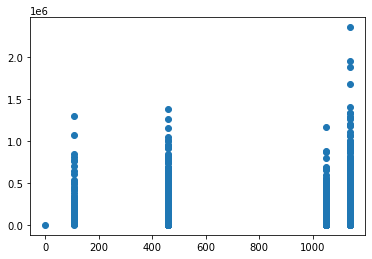

In [ ]:
plt.scatter(ctf.fit_transform(X_train), y_train)

# 3. Ordinal Transformer

<font color='red'>Assignment:</font> The relationships between the values in **product_level** can be represented by ordinal numbers. Write a class to replace the level values with their ordinal numbers.

In [ ]:
class Ordinal_Transformer():
    
    def fit(self, X, y=None):
        self.convert = {"unrated": 0, "basic": 1, "intermediate": 2, "advanced": 3, "super advanced": 4}
        
    def transform(self, X, y=None):
        ans = {"product_level": [0]*len(X)}
        for idx in range(len(X)):
            ans["product_level"][idx] = self.convert[X[idx]]
        return pd.DataFrame(ans)
        
    def fit_transform(self, X, y=None):
        self.fit(X, y)
        return self.transform(X, y)

##### <font color='red'>Questions:</font>
1. how to determine the ordinal?
2. does it matter how you determine the ordinal?

In [ ]:
otf = Ordinal_Transformer()
otf.fit_transform(X_train)

,product_level
0,3
1,1
2,1
3,3
4,4
...,...
2752,2
2753,3
2754,2
2755,3


<font color='red'>Assignment:</font> Plot the relationship between **product_level** ordinal numbers and **price**.

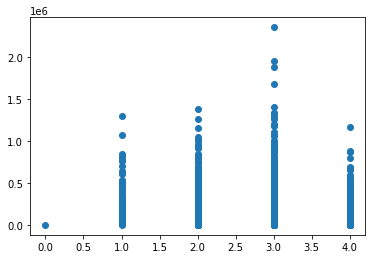

In [ ]:
plt.scatter(otf.fit_transform(X_train), y_train)

# 4. Text Vectorization

Column **ingredient** is more complex. There are missing values. And also many rows contains multiple ingredients.

## 4.1 Missing values

<font color='red'>Assignment:</font> In **train_raw**, impute the missing values in **ingredient** as **unknown_ingredient**, and assign the imputed **ingredient** to a variable **train_imputed_ingredient**.

In [ ]:
train_imputed_ingredient = train_raw["ingredient"].fillna("unknown_ingredient")

<font color='red'>Questions:</font> What are other ways to impute or handle missing categorical values? What are the good ways to handle different amounts of missing categorical values, like a few lines, a small fraction (say 2%), a considerable fraction (say 30%), and majority (say 95%)?

**ANS:**
<br>Handle missing categorical values:
<br>1. Ignor there missing values
<br>2. Replace with most frequent value
<br>3. Replace using an algorithm like KNN using the neighbours
<br>4. Predict the observation using a multiclass predictor.
<br>
<br>A few line: drop the missing values
<br>A small fraction: replace with most frequent value
<br>A considerable fraction: build a model to predict the value
<br>Majority: if the NaN means 0 or has obvious meaning, then imput. Otherwise, ignor the variable

## 4.2 Countvectorizer

**Example:** Import **CountVectorizer**

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

<font color='red'>Assignment:</font> Fit and transform **train_imputed_ingredient** using **CountVectorizer**. Assign the output to **X_train**.

In [ ]:
cv = CountVectorizer()
X_train = cv.fit_transform(train_imputed_ingredient)

<font color='red'>Assignment:</font> Get the type and shape of **X_train**. 

In [ ]:
print("Type:", type(X_train))
print("Shape:", X_train.shape)

Type: <class 'scipy.sparse.csr.csr_matrix'>
Shape: (2757, 1858)


In [ ]:
cv.transform(X_test)

<429x1858 sparse matrix of type '<class 'numpy.int64'>'
	with 1954 stored elements in Compressed Sparse Row format>

<font color='red'>Question:</font> What is a sparse matrix?

**ANS:**
<br>A sparse matrix is a matrix in which most of the elements are zero.

**Example**: Assign the output of **ingredient** generated with **CountVectorizer** to a DataFrame named **train_ingredient_df**, name the columns with features. 

In [ ]:
train_ingredient_df = pd.DataFrame(X_train.todense())
train_ingredient_df = train_ingredient_df.rename(columns={v: k for k, v in cv.vocabulary_.items()})
train_ingredient_df.head()

,in732052,in732053,in732054,in732055,in732056,in732057,in732058,in732059,in732060,in732061,...,in734073,in734074,in734075,in734076,in734079,in734080,in734081,in734086,in734087,unknown_ingredient
0,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,1,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0



<font color='red'>Assignment:</font> Train a new model using **Pipeline** to wrap up **CountVectorizer** and **LinearRegression** to predict **price**, and get both the train and test scores.

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

X_train = train_raw["ingredient"].fillna("unknown_ingredient")
y_train = train_raw["price"].map(price2num)

X_test = test_raw["ingredient"].fillna("unknown_ingredient")
y_test = test_raw["price"].map(price2num)

steps = [("cv", CountVectorizer()), ("lr", LinearRegression())]

model = Pipeline(steps)
model = model.fit(X_train, y_train)

In [ ]:
'''Train'''

y_train_pred = model.predict(X_train)

print("Train MAE: {0:0.2e}".format(mean_absolute_error(y_train, y_train_pred)))
print("Train MSE: {0:0.2e}".format(mean_squared_error(y_train, y_train_pred)))
print("Train R2 score: {0:0.3f}".format(r2_score(y_train, y_train_pred)))

Train MAE: 5.22e+04
Train MSE: 6.94e+09
Train R2 score: 0.837


In [ ]:
'''Test'''

y_test_pred = model.predict(X_test)

print("Test MAE: {0:0.2e}".format(mean_absolute_error(y_test, y_test_pred)))
print("Test MSE: {0:0.2e}".format(mean_squared_error(y_test, y_test_pred)))
print("Test R2 score: {0:0.3f}".format(r2_score(y_test, y_test_pred)))

Test MAE: 4.65e+05
Test MSE: 5.47e+11
Test R2 score: -5.347


##### <font color = 'blue'> Is this test result strange? </font>

##### dont't fit on test data